# Processing dataset and creation of Dataloaders

In [1]:
# Import standard libraries
import sys, os, random, shutil
from pathlib import Path
# For audio and MIDI processing
import pretty_midi
import IPython
# For numerical processing
import numpy as np
import torch
# For parallel processing
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
# For statistical analysis
from collections import Counter
# For plotting
import matplotlib.pyplot as plt
# For saving data of segments
import pandas as pd

import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
import time
import gc

# Import this project modules
REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from src.data.dataset import PianoDataset, PianoMmapDataset, MidiPreprocessor, create_mmap_dataset
from src.utils.visualization import display_prettymidi
from src.utils.tools import piano_roll_to_pretty_midi

## Pretty_midi --> matrix (parallel processing for whole dataset)

Poichè trasformare un file midi in una matrice non è computazionalmente semplice se bisogna farlo su migliaia di file, conviene preprocessare prima del training ogni file midi e salvare i risultati in una cartella.
Per rendere il processo ancora più efficiente questo procedimento viene eseguito in parallelo su tutti i core disponibili della cpu.
Al momento quello che viene fatto è:

1. da ciascun file MIDI vengono separate le tracce al piano
2. viene suddiviso in sezioni a bpm costante
3. per ciascuna di queste viene estratto un piano-roll
4. il piano roll viene segmentato in porzioni di lunghezza 128 battiti che corrispondono a 8 bars in 4/4

Ogni segmento viene salvato in una versione sparsa e compattata in un file .npz.
Per modificare il preprocessing modificare `MidiPreprocessor`.

In [2]:
clean_midi_path = REPO_ROOT / 'data' / 'prove'
npz_path = REPO_ROOT / 'data' / 'processed_npz'
mmap_path = REPO_ROOT / 'data' / 'piano_dataset.dat'
processing_results_path = REPO_ROOT / 'data' / 'processing_results_details.txt'
segments_details_path = REPO_ROOT / 'data' / 'segments_metadata.txt'

# Solves problem "Adventures of Stevie V." (path with final dot)
if os.name == 'nt':
    clean_midi_path = Path(f"\\\\?\\{str(clean_midi_path.resolve())}")

# Get list of all MIDI files
midi_files = list(clean_midi_path.rglob('*.mid'))

selected_instruments = range(8)  # Piano and related instruments

Questa cella si può saltare se il preprocessing è già stato fatto.

In [3]:
# Clean the whole directory
shutil.rmtree(npz_path)
npz_path.mkdir(parents=True, exist_ok=True)
(npz_path / '.gitkeep').touch()

# Initialize Stats
valid_source_files = 0
total_segments = 0
error_counts = Counter()
detailed_errors = []

# Initialize Processor
processor = MidiPreprocessor(
    select_instruments=selected_instruments, 
    note_start=24, 
    note_end=84, 
    output_dir=npz_path,
)

print(f"Starting preprocessing. Metadata will be written in real-time to: {segments_details_path}")

# --- CORE LOGIC ---
with open(segments_details_path, 'w') as f_meta:
    # Write the header
    f_meta.write("filename\tinstrument\tfs\tbpm\n")

    # Start the process Pool
    with Pool(processes=cpu_count()) as pool:
        
        # process files in parallel with imap_unordered for streaming results
        iterator = pool.imap_unordered(processor, midi_files, chunksize=10)
        for result in tqdm(iterator, total=len(midi_files), desc="Processing & Streaming", ncols=150):

            # Positive result analysis
            if isinstance(result, list):
                valid_source_files += 1
                total_segments += len(result)
                # Immediate writing to disk
                for seg in result:
                    f_meta.write(f"{seg['filename']}\t{seg['instrument']}\t{seg['fs']:.2f}\t{seg['bpm']:.2f}\n")
            # Error storage
            elif isinstance(result, str):
                if result.startswith("ERROR"):
                    error_counts["Exception"] += 1
                    detailed_errors.append(result)
                elif result.startswith("DISCARDED"):
                    if "NO PIANO" in result:
                        error_counts["No Piano"] += 1
                    elif "NO VALID SEGMENTS" in result:
                        error_counts["Segment Invalid"] += 1
                    else:
                        error_counts["Other Discard"] += 1

# Save results and stats
with open(processing_results_path, 'w') as f:
    f.write("="*50 + "\n")
    f.write(f"{'REPORT PREPROCESSING':^50}" + "\n")
    f.write("="*50 + "\n\n")

    f.write(f"{'Total files processed:':<35}{len(midi_files):>15}\n")
    f.write(f"{'Of which valid source files:':<35}{valid_source_files:>15}\n")
    f.write(f"{'Discarded files (No Piano):':<35}{error_counts['No Piano']:>15}\n")
    f.write(f"{'Discarded files (Invalid Segments):':<35}{error_counts['Segment Invalid']:>15}\n")
    f.write(f"{'Errors (Exceptions):':<35}{error_counts['Exception']:>15}\n\n")
    f.write(f"{'Total segments created:':<35}{total_segments:>15}\n\n")

    f.write(f"{' Error Details ':=^50}" + "\n\n")
    for error in detailed_errors:
        f.write(error + "\n")

# Consolidate all .npz files into a single memory-mapped dataset
create_mmap_dataset(npz_path, mmap_path)

Starting preprocessing. Metadata will be written in real-time to: C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\data\segments_metadata.txt


Consolidating .npz files: 100%|██████████████████████████████████████████████████████████████████████████████████| 2191/2191 [00:12<00:00, 175.34it/s]


               REPORT PREPROCESSING

Total files processed:                         299
Of which valid source files:                   203
Discarded files (No Piano):                     89
Discarded files (Invalid Segments):              7
Errors (Exceptions):                             0

Total segments created:                       2191

================= Error Details ==================



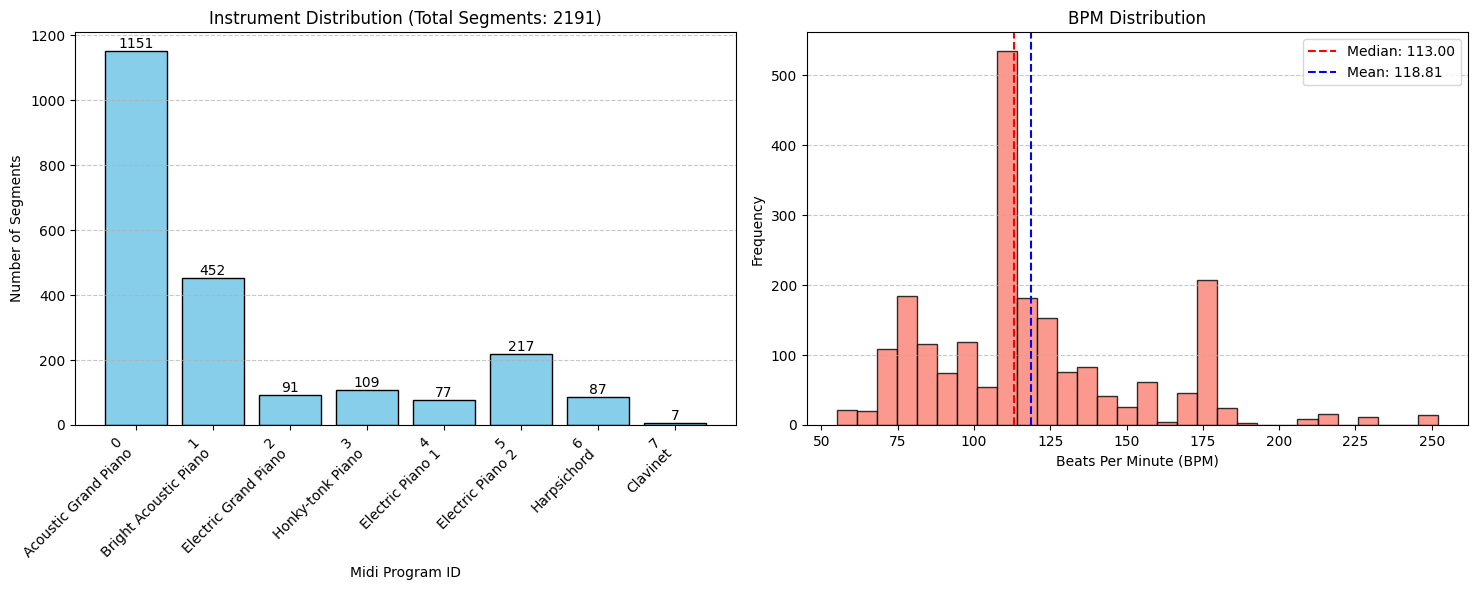

In [4]:
try:
    with open(processing_results_path, 'r') as f:
        for _ in range(20):
            line = f.readline()
            if not line:
                break
            print(line.rstrip())

except FileNotFoundError:
    print(f"File not found: {processing_results_path}")
    
try:
    df_analysis = pd.read_csv(segments_details_path, sep='\t')
    df_analysis = df_analysis.set_index('filename')

    # Extraction data from columns
    instruments = df_analysis['instrument'].values
    bpms = df_analysis['bpm'].values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- Histogram Instruments ---
    instr_counts = Counter(instruments)
    
    # Identify present instruments
    present_instrs = sorted(list(instr_counts.keys()))
    counts = [instr_counts[i] for i in present_instrs]
    # Obtain readable names
    instr_labels = [pretty_midi.program_to_instrument_name(int(i)) for i in present_instrs]
    
    # Display Bars
    bars = ax1.bar([str(i) for i in present_instrs], counts, color='skyblue', edgecolor='black')
    ax1.set_title(f'Instrument Distribution (Total Segments: {len(df_analysis)})')
    ax1.set_xlabel('Midi Program ID')
    ax1.set_ylabel('Number of Segments')
    # Customize x-ticks with instrument names
    ax1.set_xticks(range(len(present_instrs)))
    ax1.set_xticklabels([f"{i}\n{l}" for i, l in zip(present_instrs, instr_labels)], rotation=45, ha='right')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

    # --- Histogram BPM ---
    ax2.hist(bpms, bins=30, color='salmon', edgecolor='black', alpha=0.8)
    ax2.set_title('BPM Distribution')
    ax2.set_xlabel('Beats Per Minute (BPM)')
    ax2.set_ylabel('Frequency')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Statistics
    median_bpm = np.median(bpms)
    mean_bpm = np.mean(bpms)
    
    ax2.axvline(median_bpm, color='red', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bpm:.2f}')
    ax2.axvline(mean_bpm, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_bpm:.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("ERROR: File not found. Run the saving step first.")

## Load the datasets

In [5]:
def benchmark_loader(loader, num_epochs=1):
    print(f"Start benchmark on {len(loader)} batches for {num_epochs} epochs...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Simulating transfer to: {device}")

    start_time = time.time()
    total_batches = 0
    
    for epoch in range(num_epochs):
        # tqdm gives us a progress bar with real-time speed estimation
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch_idx, (prev_bar, curr_bar) in enumerate(pbar):
            # We simulate ONLY the transfer to GPU memory (which has a cost)
            # We do not perform forward/backward pass
            prev_bar = prev_bar.to(device, non_blocking=True)
            curr_bar = curr_bar.to(device, non_blocking=True)
            
            total_batches += 1
            
    end_time = time.time()
    total_time = end_time - start_time
    
    print("\n=== Benchmark Results ===")
    print(f"Total Time: {total_time:.2f} seconds")
    print(f"Batches Processed: {total_batches}")
    print(f"Mean Velocity: {total_batches / total_time:.2f} batch/second")
    print(f"Throughput: {(total_batches * loader.batch_size) / total_time:.2f} samples/second")
    print("===========================")

### Previus dataset loader using npz

Ha anche il problema che ogni sample estratto dal dataset era un segmento che costituisce in realta 8 coppie (prev_bar, curr_bar) che però non sono i.i.d. e quindi non vanno bene per il training.
La soluzione in questo caso sarebbe estrarre una sola coppia per segmento, ma allora il problema si sposta al fatto che stiamo caricando dati inutili in memoria.

Start benchmark on 438 batches for 3 epochs...
Simulating transfer to: cuda


Epoch 1/3:   0%|          | 0/438 [00:00<?, ?batch/s]

Epoch 3/3: 100%|██████████| 438/438 [00:22<00:00, 19.55batch/s]



=== Benchmark Results ===
Total Time: 66.64 seconds
Batches Processed: 1314
Mean Velocity: 19.72 batch/second
Throughput: 630.93 samples/second
Previous bars shape: torch.Size([32, 128, 16])
Current bars shape: torch.Size([32, 128, 16])


C:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\src\utils\visualization.py:24: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


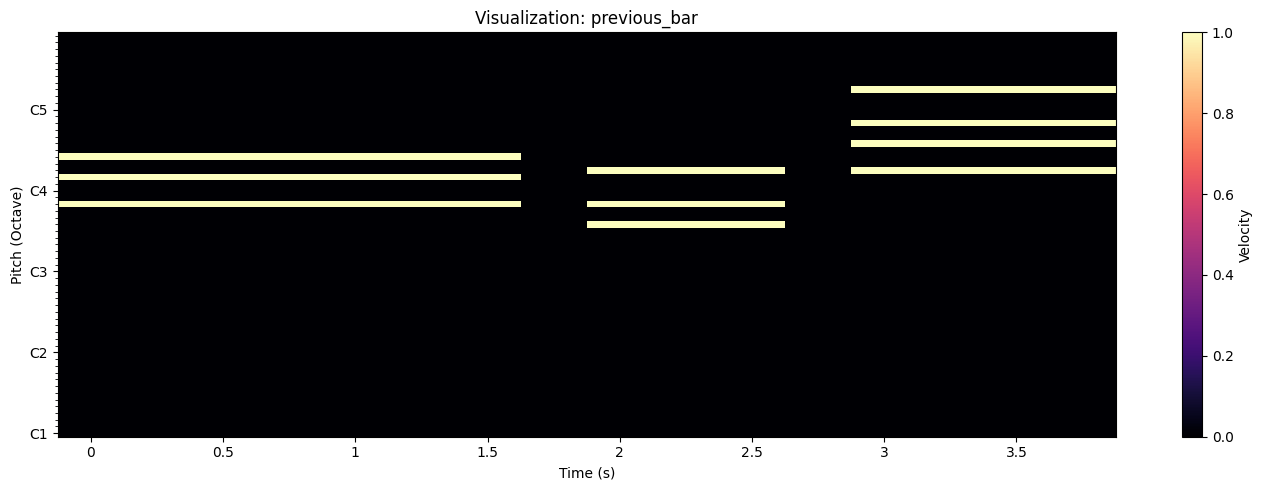

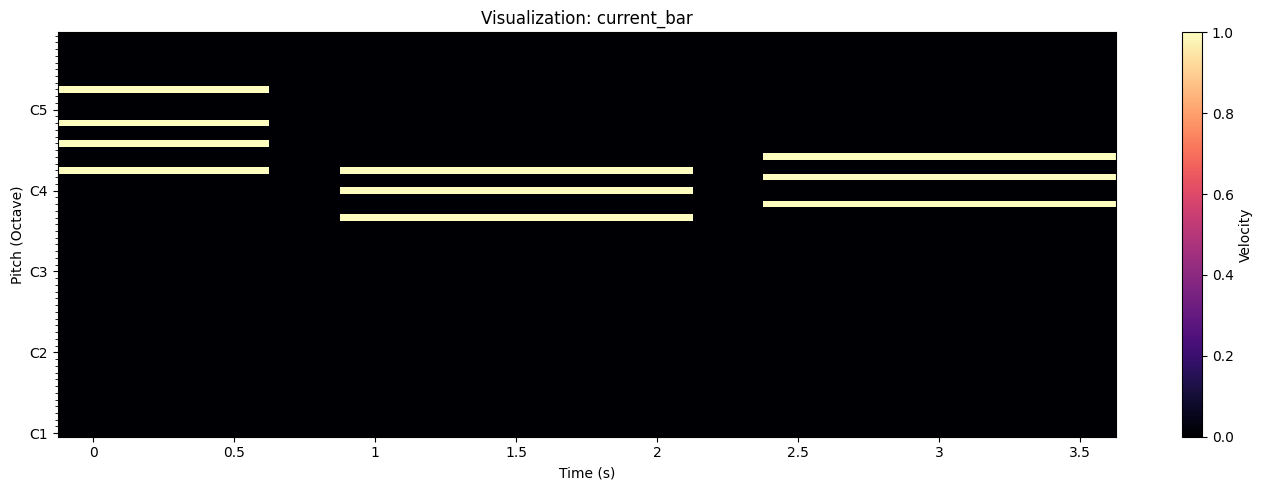

In [7]:
npz_files = list(npz_path.glob('*.npz'))

train_size = int(0.8 * len(npz_files))
val_size = len(npz_files) - train_size
train_paths, val_paths = torch.utils.data.random_split(npz_files, [train_size, val_size])

# Instantiate the Datasets
train_dataset = PianoDataset(train_paths)
val_dataset = PianoDataset(val_paths)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Benchmark the DataLoader
benchmark_loader(train_loader, num_epochs=3)

# Visualize a sample from the training set
prev_bar, current_bar = next(iter(train_loader))
print("Previous bars shape:", prev_bar.shape)
print("Current bars shape:", current_bar.shape)

prev_pm = piano_roll_to_pretty_midi(prev_bar[1], fs=4)
display_prettymidi(
    prev_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: previous_bar"
)
current_pm = piano_roll_to_pretty_midi(current_bar[1], fs=4)
display_prettymidi(
    current_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: current_bar"
)

### New dataset loader using memory mapping

In questo caso ogni sample è una singola coppia (prev_bar, curr_bar) e quindi ogni estrazione è i.i.d.

Train Segments: 1752
Val Segments:   219
Test Segments:  220
Start benchmark on 195 batches for 10 epochs...
Simulating transfer to: cuda


Epoch 10/10: 100%|██████████| 195/195 [00:00<00:00, 227.77batch/s]



=== Benchmark Results ===
Total Time: 9.28 seconds
Batches Processed: 1950
Mean Velocity: 210.24 batch/second
Throughput: 15137.09 samples/second
Previous bars shape: torch.Size([72, 1, 128, 16])
Current bars shape: torch.Size([72, 1, 128, 16])


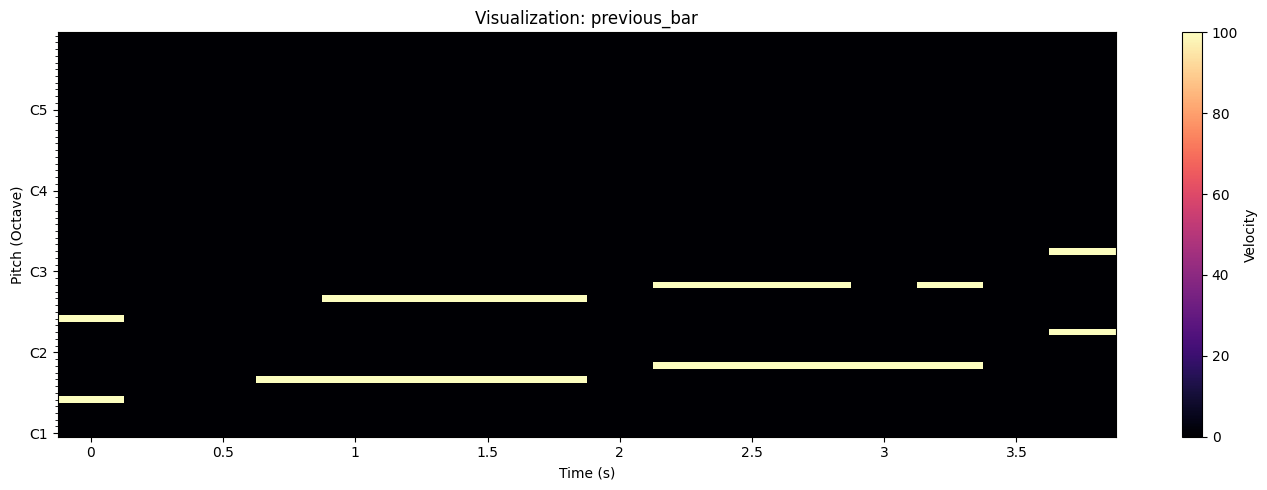

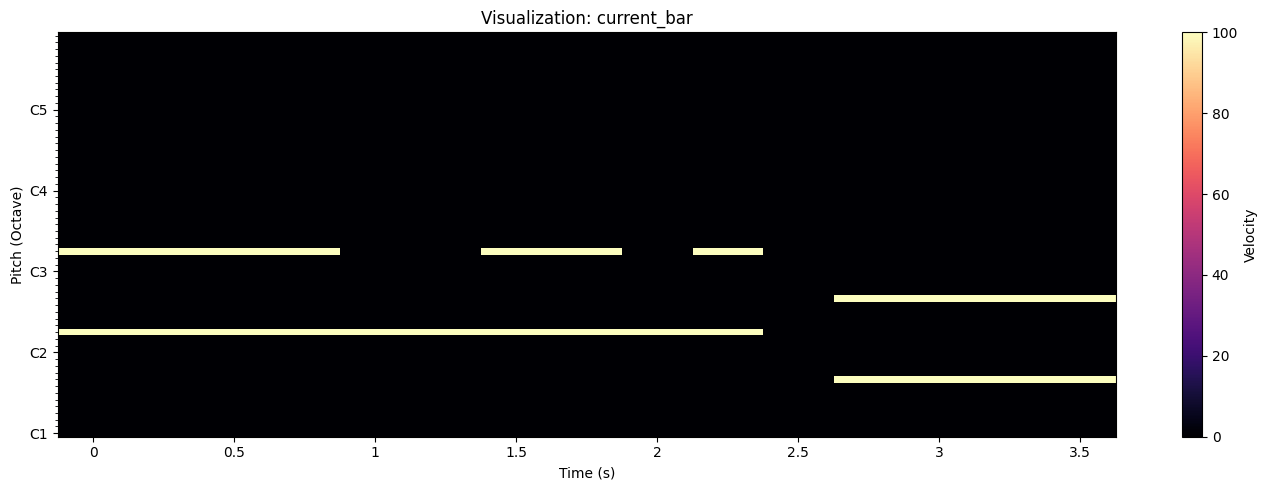

Concatenated bars shape: torch.Size([1, 128, 32])


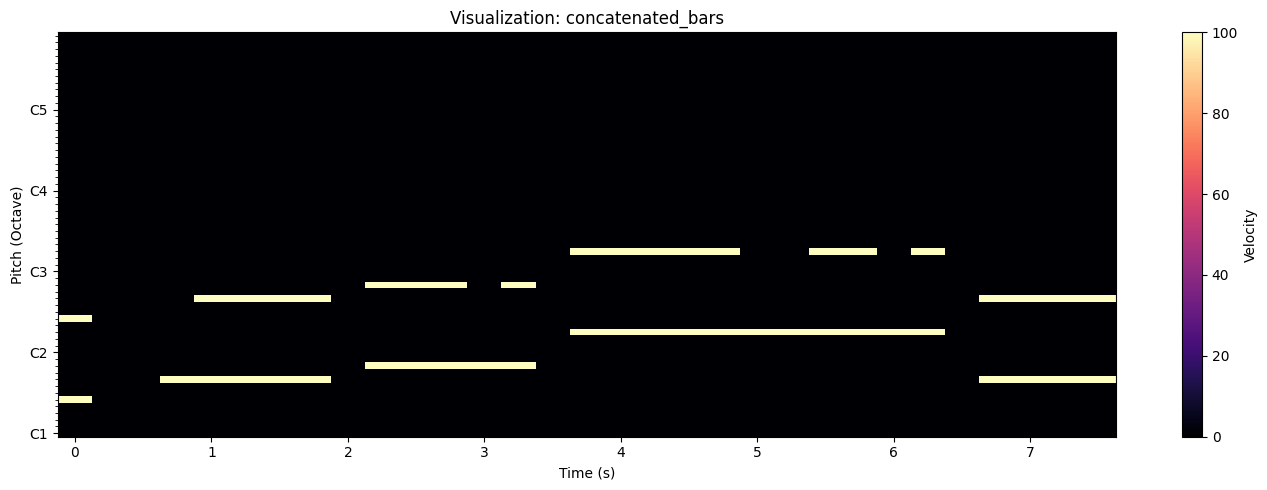

In [8]:
try:
    with open(processing_results_path, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith("Total segments created:"):
                total_segments = int(line.strip().split(":")[-1])
                break
except FileNotFoundError:
    print(f"File not found: {processing_results_path}")

all_indices = np.arange(total_segments)

# Split indices (80% Train, 10% Val, 10% Test)
train_indices, temp_indices = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, shuffle=True)

print(f"Train Segments: {len(train_indices)}")
print(f"Val Segments:   {len(val_indices)}")
print(f"Test Segments:  {len(test_indices)}")

# Instantiate the Datasets
train_dataset = PianoMmapDataset(mmap_path, split_indices=train_indices)
val_dataset   = PianoMmapDataset(mmap_path, split_indices=val_indices)
test_dataset  = PianoMmapDataset(mmap_path, split_indices=test_indices)

# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=72, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=72, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=72, shuffle=False, num_workers=0)

# Benchmark the DataLoader
benchmark_loader(train_loader, num_epochs=10)

# Visualize a sample from the DataLoader
prev_bar, current_bar = next(iter(train_loader))
print("Previous bars shape:", prev_bar.shape)
print("Current bars shape:", current_bar.shape)

prev_pm = piano_roll_to_pretty_midi(prev_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    prev_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: previous_bar"
)
current_pm = piano_roll_to_pretty_midi(current_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    current_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: current_bar"
)

# Concatenate previous and current bars
concatenated_bars = torch.cat((prev_bar[1], current_bar[1]), dim=2)  # Concatenate along time axis
print("Concatenated bars shape:", concatenated_bars.shape)

concatenated_pm = piano_roll_to_pretty_midi(concatenated_bars.squeeze().numpy()*100, fs=4)
display_prettymidi(
    concatenated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: concatenated_bars"
)

audio = IPython.display.Audio(concatenated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)